Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from ipywidgets import interact
import seaborn as sns
import missingno as msno
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor


In [82]:
# List of raw paths to your CSV files
csv_files = [
    '/content/drive/MyDrive/Rainfall_prediction/Erode.csv',
    '/content/drive/MyDrive/Rainfall_prediction/Karur.csv',
    '/content/drive/MyDrive/Rainfall_prediction/Dindigul.csv',
]
data = pd.DataFrame()
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    data = pd.concat([data, df], ignore_index=True)

data.isnull().sum()


Station Code             0
Station Name             0
District                 0
Latitude                 0
Longitude                0
Year                     0
Month                    0
Day                      0
Hour                     0
Min Temperature      13295
Max Temperature       6790
Temp Dry Bulb          171
Temp Wet Bulb          684
Relative Humidity     1038
Inst Wind Speed      28385
Av Wind Speed        33056
Wind direction        1166
Pan Evaporation        272
Rainfall               344
dtype: int64

In [83]:
data['Hour'] = pd.to_datetime(data['Hour'], format='%H:%M', errors='coerce', exact=False)
data['Hour_Hour'] = data['Hour'].dt.minute
data['Hour_Minute'] = data['Hour'].dt.hour
years = data['Year'].unique()
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999])

In [84]:
months = data['Month'].unique()
months

array([ 1,  2,  3,  4,  5,  7,  8,  9, 11,  6, 10, 12])

In [85]:
#seasonal filling for nulls
def seasonal_fill(column):
  c = 0
  yearly = []
  for year in years :
    monthly = []
    for month in range(1,13):
      selected_rows = data[(data['Year'] == year) & (data['Month'] == month)]
      monthly_avg = selected_rows[column].mean()
      data.loc[(data['Year'] == year) & (data['Month'] == month), column] = monthly_avg
      monthly.append(monthly_avg)
    yearly.append(monthly)
  means = []
  for i in range(len(yearly[0])):
    values = []
    for j in range(len(yearly)):
      values.append(yearly[j][i])
    mean = np.nanmean(values)
    means.append(mean)
  print(means)
  for val in range(len(means)):
    data.loc[(data['Month'] == val+1) & (data[column].isna()|data[column].isnull()), column] = means[val]


seasonal_fill('Temp Dry Bulb')
seasonal_fill('Temp Wet Bulb')
seasonal_fill('Relative Humidity')
seasonal_fill('Inst Wind Speed')
seasonal_fill('Av Wind Speed')
seasonal_fill('Pan Evaporation')

[26.186989507084597, 28.16411558820574, 30.626233191464834, 32.09952389230867, 31.65700084675969, 30.304046570357983, 29.701070400497585, 29.476777533645002, 29.338275870332026, 28.14353909956386, 26.71213460140465, 25.802165270075708]
[21.316738098927303, 21.957194985810585, 23.35081538985908, 24.917135470828246, 25.15064366786141, 24.414299391748216, 23.989092752320126, 23.982389402531428, 24.05680614312553, 24.141392055538155, 23.431064474990656, 22.079262036856733]
[65.27912193254039, 58.93264957032703, 55.3997527261906, 56.34325935903057, 59.101488118540566, 60.57039338445674, 61.2372636177518, 62.486803306603825, 64.18337656564665, 71.73795381027364, 75.636441453239, 72.23841530046101]
[2.641116406227801, 3.8550419728914083, 4.328516157467603, 4.0099880519438615, 5.662060129539515, 8.502199618736382, 10.120226423839915, 8.226948298132786, 5.573018871956304, 2.957848475674625, 1.9629878795173614, 2.278294531774046]
[3.130772488206804, 3.398680330682503, 3.491500904850055, 3.922291

In [6]:
data.isnull().sum()

Station Code             0
Station Name             0
District                 0
Latitude                 0
Longitude                0
Year                     0
Month                    0
Day                      0
Hour                     0
Min Temperature      13295
Max Temperature       6790
Temp Dry Bulb            0
Temp Wet Bulb            0
Relative Humidity        0
Inst Wind Speed          0
Av Wind Speed            0
Wind direction        1166
Pan Evaporation          0
Rainfall               344
Hour_Hour                0
Hour_Minute              0
dtype: int64

In [86]:
#padding
columns_to_fill = ['Min Temperature', 'Max Temperature','Rainfall']
data[columns_to_fill] = data[columns_to_fill].fillna(method='ffill')

In [87]:
#one hot encoding categorical values
data['Wind direction'].unique()
data_encoded = pd.get_dummies(data, columns=['Wind direction'], prefix='Wind_direction')
print(data_encoded)

       Station Code                    Station Name  District   Latitude  \
0       BAVANISAGAR  Bhavanisagar FCS                   Erode  11°28'24"   
1       BAVANISAGAR  Bhavanisagar FCS                   Erode  11°28'24"   
2       BAVANISAGAR  Bhavanisagar FCS                   Erode  11°28'24"   
3       BAVANISAGAR  Bhavanisagar FCS                   Erode  11°28'24"   
4       BAVANISAGAR  Bhavanisagar FCS                   Erode  11°28'24"   
...             ...                             ...       ...        ...   
108498  VIRALIPATTI  Viralipatti                     Dindigul  10°07'33"   
108499  VIRALIPATTI  Viralipatti                     Dindigul  10°07'33"   
108500  VIRALIPATTI  Viralipatti                     Dindigul  10°07'33"   
108501  VIRALIPATTI  Viralipatti                     Dindigul  10°07'33"   
108502  VIRALIPATTI  Viralipatti                     Dindigul  10°07'33"   

        Longitude  Year  Month  Day                Hour  Min Temperature  ...  \
0     

In [88]:
data.isnull().sum()

Station Code            0
Station Name            0
District                0
Latitude                0
Longitude               0
Year                    0
Month                   0
Day                     0
Hour                    0
Min Temperature         0
Max Temperature         0
Temp Dry Bulb           0
Temp Wet Bulb           0
Relative Humidity       0
Inst Wind Speed         0
Av Wind Speed           0
Wind direction       1166
Pan Evaporation         0
Rainfall                0
Hour_Hour               0
Hour_Minute             0
dtype: int64

In [89]:
mae_l = []
mse_l = []
rmse_l = []
r2_l = []
def Metrics(ytest, ypred):
    mae = mean_absolute_error(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    rmse = mse ** 0.5
    r2 = r2_score(ytest, ypred)
    mae_l.append(mae)
    mse_l.append(mse)
    rmse_l.append(rmse)
    r2_l.append(r2)
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-Squared: ", r2)

In [100]:
X = data[[
    "Year",
    "Month",
    "Day",
    "Hour_Hour",
    "Hour_Minute",
    "Rainfall",
    "Min Temperature",
    "Max Temperature",
    "Temp Dry Bulb",
    "Temp Wet Bulb",
    "Relative Humidity",
    "Inst Wind Speed",
    "Av Wind Speed",
    "Pan Evaporation"]]
y = data['Rainfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
#GradientBOOST
gb_regressor = GradientBoostingRegressor(n_estimators=110, random_state=42)
gb_regressor.fit(X_train, y_train)
y_pred = gb_regressor.predict(X_test)

Metrics(y_test,y_pred)

MAE:  0.009810612420774628
MSE:  0.16707774029853603
RMSE:  0.40875144072961506
R-Squared:  0.995534878943445


In [24]:
import pickle
with open('/content/drive/MyDrive/Rainfall_prediction/gb_regressor.pkl','wb') as file:
  pickle.dump(gb_regressor,file)

In [99]:
with open('/content/drive/MyDrive/Rainfall_prediction/gb_regressor.pkl','rb') as file:
  gb_regressor = pickle.load(file)
  #y_pred = gb_regressor.predict(X_test)
  #Metrics(y_test,y_pred)

In [28]:
#random forest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

Metrics(y_test,y_pred)

MAE:  0.00846051426991511
MSE:  0.36464945597738907
RMSE:  0.6038621166933633
R-Squared:  0.9902548121536915


In [29]:
with open('/content/drive/MyDrive/Rainfall_prediction/rf_regressor.pkl','wb') as file:
  pickle.dump(rf_regressor,file)

In [103]:
with open('/content/drive/MyDrive/Rainfall_prediction/rf_regressor.pkl','rb') as file:
  rf_regressor = pickle.load(file)
  #y_pred = regressor.predict(X_test)
  #Metrics(y_test,y_pred)

In [38]:
#knn
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

Metrics(y_test,y_pred)

MAE:  0.1617621578446131
MSE:  0.627566511627907
RMSE:  0.7921909565426173
R-Squared:  0.983228403493777


In [39]:
with open('/content/drive/MyDrive/Rainfall_prediction/knn.pkl','wb') as file:
  pickle.dump(knn_model,file)

In [93]:
with open('/content/drive/MyDrive/Rainfall_prediction/knn.pkl','rb') as file:
  regressor = pickle.load(file)
  y_pred = regressor.predict(X_test)
  Metrics(y_test,y_pred)

MAE:  0.1617621578446131
MSE:  0.627566511627907
RMSE:  0.7921909565426173
R-Squared:  0.983228403493777


In [61]:
#Exponential smoothening
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('Date', inplace=True)
rainfall_series = data['Rainfall']
model = ExponentialSmoothing(rainfall_series, seasonal='add',seasonal_periods = 7)
model_fit = model.fit()
y_pred = model_fit.fittedvalues

Metrics(data['Rainfall'],y_pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.



MAE:  1.6790089903995677
MSE:  31.6720517150909
RMSE:  5.627792792480094
R-Squared:  0.018127157577980446


In [64]:
with open('/content/drive/MyDrive/Rainfall_prediction/exponential_smoothening.pkl','wb') as file:
  pickle.dump(model_fit,file)

In [94]:
with open('/content/drive/MyDrive/Rainfall_prediction/exponential_smoothening.pkl','rb') as file:
  regressor = pickle.load(file)
  y_pred = regressor.fittedvalues
  Metrics(data['Rainfall'],y_pred)

MAE:  1.6790089903995677
MSE:  31.6720517150909
RMSE:  5.627792792480094
R-Squared:  0.018127157577980446


In [66]:
#ARIMA
p = 1
d = 1
q = 7
model = ARIMA(data['Rainfall'], order=(p, d, q))
model_fit = model.fit()
start = 0
end = len(data['Rainfall']) - 1
predictions = model_fit.predict(start=start, end=end, typ='levels')
actual_values = data['Rainfall'][start:end+1]
Metrics(actual_values,predictions)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency infor

MAE:  1.6496458907737803
MSE:  30.823617128989998
RMSE:  5.551902118102407
R-Squared:  0.04442968089279031


In [67]:
with open('/content/drive/MyDrive/Rainfall_prediction/arima.pkl','wb') as file:
  pickle.dump(model_fit,file)

In [95]:
with open('/content/drive/MyDrive/Rainfall_prediction/arima.pkl','rb') as file:
  regressor = pickle.load(file)
  start = 0
  end = len(data['Rainfall']) - 1
  predictions = regressor.predict(start=start, end=end, typ='levels')
  actual_values = data['Rainfall'][start:end+1]
  Metrics(actual_values,predictions)

MAE:  1.6496458907737803
MSE:  30.823617128989998
RMSE:  5.551902118102407
R-Squared:  0.04442968089279031


In [96]:
import random
selected_columns = [
    "Year", "Month", "Day", "Hour_Hour", "Hour_Minute", "Rainfall",
    "Min Temperature", "Max Temperature", "Temp Dry Bulb", "Temp Wet Bulb",
    "Relative Humidity", "Inst Wind Speed", "Av Wind Speed", "Pan Evaporation"
]

data_subset = data[selected_columns]
X = data_subset.drop("Rainfall", axis=1)
y = data_subset["Rainfall"]
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

sequence_length = 24
num_features = X_scaled.shape[1]
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - sequence_length + 1):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length-1])

X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)
train_size = int(0.7 * len(X_sequences))
val_size = int(0.2 * len(X_sequences))
test_size = len(X_sequences) - train_size - val_size
indices = list(range(len(X_sequences)))
random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]
X_train, y_train = X_sequences[train_indices], y_sequences[train_indices]
X_val, y_val = X_sequences[val_indices], y_sequences[val_indices]
X_test, y_test = X_sequences[test_indices], y_sequences[test_indices]


In [70]:
#lstm
model = Sequential([
    LSTM(units=64, input_shape=(sequence_length, num_features), activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(units=32, activation='relu'),
    Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
loss = model.evaluate(X_test, y_test)

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

Metrics(y_test,y_pred)

Epoch 1/5
2373/2373 [==============================] - 118s 45ms/step - loss: 0.9971 - val_loss: 0.8565
Epoch 2/5
2373/2373 [==============================] - 131s 55ms/step - loss: 0.9322 - val_loss: 0.8327
Epoch 3/5
2373/2373 [==============================] - 110s 46ms/step - loss: 0.9063 - val_loss: 0.8172
Epoch 4/5
2373/2373 [==============================] - 147s 62ms/step - loss: 0.8863 - val_loss: 0.7934
Epoch 5/5
339/339 [==============================] - 4s 11ms/step
MAE:  1.2479186181378747
MSE:  6.365708093729114
RMSE:  2.523035491967783
R-Squared:  -6.66139965808941


In [73]:
with open('/content/drive/MyDrive/Rainfall_prediction/lstm.pkl','wb') as file:
  pickle.dump(model,file)

In [97]:
with open('/content/drive/MyDrive/Rainfall_prediction/lstm.pkl','rb') as file:
  regressor = pickle.load(file)
  y_pred_scaled = regressor.predict(X_test)
  y_pred = scaler_y.inverse_transform(y_pred_scaled)
  Metrics(y_test,y_pred)

339/339 [==============================] - 3s 8ms/step
MAE:  1.275331023703515
MSE:  6.594620848946986
RMSE:  2.5679993864771435
R-Squared:  -5.329884446817219


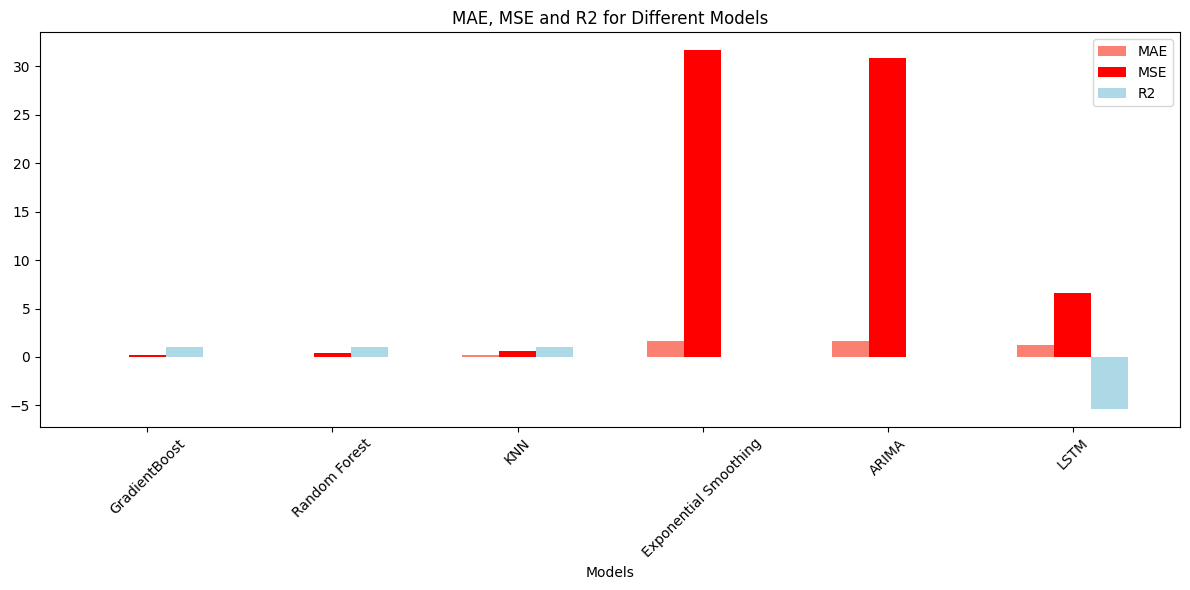

In [98]:
#comparing all the models
import matplotlib.pyplot as plt
import numpy as np

model_names = ["GradientBoost", "Random Forest", "KNN","Exponential Smoothing",'ARIMA', "LSTM"]

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(model_names))

ax.bar(index - bar_width, mae_l, bar_width, color='salmon', label='MAE')
ax.bar(index, mse_l, bar_width, color='red', label='MSE')
ax.bar(index + bar_width, r2_l, bar_width, color='lightblue', label='R2')

ax.set_xlabel("Models")
ax.set_title("MAE, MSE and R2 for Different Models")
ax.set_xticks(index)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


In [106]:
X = data[[
    "Year",
    "Month",
    "Day",
    "Hour_Hour",
    "Hour_Minute",
    "Rainfall",
    "Min Temperature",
    "Max Temperature",
    "Temp Dry Bulb",
    "Temp Wet Bulb",
    "Relative Humidity",
    "Inst Wind Speed",
    "Av Wind Speed",
    "Pan Evaporation"]]
y = data['Rainfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [101]:
from sklearn.model_selection import cross_val_score
CV_MSE = np.mean(-cross_val_score(gb_regressor, X_train, y_train, cv = 10 ,scoring = "neg_mean_squared_error" ))
CV_RMSE = np.sqrt(CV_MSE)
print("Validated Mean Squared Error on training data for gradient boost regressor: ", CV_MSE)
print("Validated Root Mean Squared Error on training data for gradient boost regressor: ", CV_RMSE)

Validated Mean Squared Error on training data for gradient boost regressor:  0.008116267162049193
Validated Root Mean Squared Error on training data for gradient boost regressor:  0.09009032779410447


In [102]:
CV_MSE = np.mean(-cross_val_score(gb_regressor, X_test, y_test, cv = 10 ,scoring = "neg_mean_squared_error" ))
CV_RMSE = np.sqrt(CV_MSE)
print("Validated Mean Squared Error on test data: ", CV_MSE)
print("Validated Root Mean Squared Error on test data: ", CV_RMSE)

Validated Mean Squared Error on test data:  0.15907016733619117
Validated Root Mean Squared Error on test data:  0.39883601559562193


In [104]:
CV_MSE_RF = np.mean(-cross_val_score(rf_regressor, X_train, y_train, cv = 10 ,scoring = "neg_mean_squared_error" ))
CV_RMSE_RF = np.sqrt(CV_MSE)
print("Validated Mean Squared Error on training data for random forest regressor: ", CV_MSE_RF)
print("Validated Root Mean Squared Error on training data for random fores regressor: ", CV_RMSE_RF)

Validated Mean Squared Error on training data for random forest regressor:  0.017400021438574064
Validated Root Mean Squared Error on training data for random fores regressor:  0.39883601559562193


In [105]:
CV_MSE_RF = np.mean(-cross_val_score(rf_regressor, X_test, y_test, cv = 10 ,scoring = "neg_mean_squared_error" ))
CV_RMSE_RF = np.sqrt(CV_MSE)
print("Validated Mean Squared Error on test data: ", CV_MSE_RF)
print("Validated Root Mean Squared Error on test data: ", CV_RMSE_RF)

Validated Mean Squared Error on test data:  0.19627991686185692
Validated Root Mean Squared Error on test data:  0.39883601559562193
